In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download iarunava/cell-images-for-detecting-malaria

 97% 656M/675M [00:03<00:00, 227MB/s]
100% 675M/675M [00:03<00:00, 209MB/s]


In [7]:
!unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [8]:
len(os.listdir('/content/cell_images/cell_images/Parasitized'))

13780

In [9]:
len(os.listdir('/content/cell_images/cell_images/Uninfected'))

13780

In [10]:
base_dir = '/content/cell_images/cell_images'
data_train = os.path.join(base_dir, 'data_train')
data_test = os.path.join(base_dir, 'data_test')

In [11]:
os.mkdir(data_train)
os.mkdir(data_test)

In [12]:
train_parasitized, test_parasitized = train_test_split(os.listdir('/content/cell_images/cell_images/Parasitized'), test_size = 0.2)
train_uninfected, test_uninfected = train_test_split(os.listdir('/content/cell_images/cell_images/Uninfected'), test_size = 0.2)

In [13]:
parasitized_train = os.path.join(data_train, 'parasitized')
parasitized_test = os.path.join(data_test, 'parasitized')
uninfected_train = os.path.join(data_train, 'uninfected')
uninfected_test = os.path.join(data_test, 'uninfected')

In [14]:
os.mkdir(parasitized_train)
os.mkdir(parasitized_test)
os.mkdir(uninfected_train)
os.mkdir(uninfected_test)

In [15]:
import shutil

# parasitized
for i in train_parasitized:
  shutil.copy(os.path.join('/content/cell_images/cell_images/Parasitized', i), os.path.join(parasitized_train, i))
for i in test_parasitized:
  shutil.copy(os.path.join('/content/cell_images/cell_images/Parasitized', i), os.path.join(parasitized_test, i))

# uninfected
for i in train_uninfected:
  shutil.copy(os.path.join('/content/cell_images/cell_images/Uninfected',i), os.path.join(uninfected_train, i))
for i in test_uninfected:
  shutil.copy(os.path.join('/content/cell_images/cell_images/Uninfected',i), os.path.join(uninfected_test, i))


In [16]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range = 0.2,
                    rotation_range=20,
                    fill_mode = 'nearest',
                    horizontal_flip=True)

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range = 0.2,
                    rotation_range=20,
                    fill_mode = 'nearest',
                    horizontal_flip=True)

In [17]:
train_generator = train_datagen.flow_from_directory(
        data_train,
        target_size=(250, 250),
        batch_size=32,
        class_mode='binary',
        shuffle = True,
        seed = 53)

val_generator = test_datagen.flow_from_directory(
        data_test,
        target_size=(250, 250),
        batch_size=32,
        class_mode='binary',
        shuffle = True,
        seed = 53)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (250,250,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation= 'relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1, activation= 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 128)      0

In [19]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [20]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 92%!")
callbacks = myCallback()

In [21]:
history = model.fit(train_generator,
                    steps_per_epoch = 50,
                    epochs = 15,
                    validation_data = val_generator,
                    validation_steps = 10,
                    verbose = 1,
                    callbacks = [callbacks]
                   )

Epoch 1/15
50/50 [==============================] - 278s 6s/step - loss: 0.7892 - accuracy: 0.5825 - val_loss: 0.6443 - val_accuracy: 0.6469
Epoch 2/15
50/50 [==============================] - 277s 6s/step - loss: 0.6523 - accuracy: 0.6131 - val_loss: 0.5579 - val_accuracy: 0.7719
Epoch 3/15
50/50 [==============================] - 275s 5s/step - loss: 0.6454 - accuracy: 0.6837 - val_loss: 0.6414 - val_accuracy: 0.6594
Epoch 4/15
50/50 [==============================] - 275s 6s/step - loss: 0.4819 - accuracy: 0.7887 - val_loss: 0.3435 - val_accuracy: 0.8687
Epoch 5/15
50/50 [==============================] - 274s 5s/step - loss: 0.3485 - accuracy: 0.8881 - val_loss: 0.6907 - val_accuracy: 0.9156
Epoch 6/15
50/50 [==============================] - 276s 6s/step - loss: 0.2825 - accuracy: 0.9112 - val_loss: 0.2188 - val_accuracy: 0.9250
Epoch 7/15
50/50 [==============================] - 275s 6s/step - loss: 0.2001 - accuracy: 0.9394 - val_loss: 0.4086 - val_accuracy: 0.9125
Epoch 8/15
50

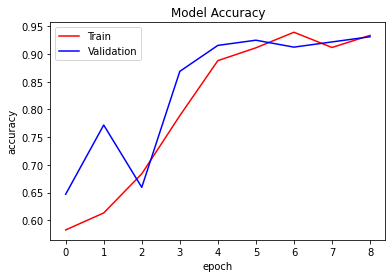

<Figure size 432x288 with 0 Axes>

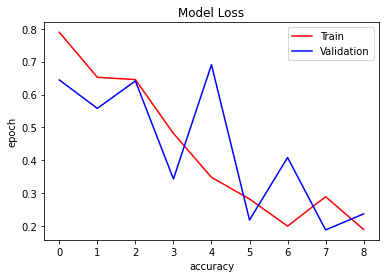

<Figure size 432x288 with 0 Axes>

In [24]:
acc = history.history['accuracy']                                               
val_acc = history.history['val_accuracy'] 

loss = history.history['loss']                                                   
val_loss = history.history['val_loss']                                           

epochs = range(len(acc))                                                       

plt.plot(epochs, acc,'r', label='Train')                                                
plt.plot(epochs, val_acc,'b', label='Validation')                         
plt.title('Model Accuracy')  
plt.xlabel('epoch')
plt.ylabel('accuracy')                                    
plt.legend(loc=0)                                                               
plt.figure()                                                                      
plt.show()


plt.plot(epochs, loss, 'r', label = 'Train' )
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Model Loss')
plt.ylabel('epoch')
plt.xlabel('accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [25]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Commented out IPython magic to ensure Python compatibility.
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.pb') 
# %cd